In [1]:
"""Example showing the optimization and evolution of surrogates"""

# Copyright (c) 2024 Alliance for Sustainable Energy, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__version__ = "0.5.1"
__deprecated__ = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d(x, y, FX, bounds, label):
    fig, ax = plt.subplots()
    im = ax.imshow(FX, cmap="jet", extent=[bounds[0][0],bounds[0][1],bounds[1][1],bounds[1][0]])
    fig.colorbar(im, ax=ax, label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.scatter(x[0:len(x)-1],y[0:len(x)-1],c='gray',marker='x')
    ax.scatter(x[-1],y[-1],c='w',marker='x')
    return fig, ax

In [3]:
def ackley(x, n: int = 2):
    from math import exp, sqrt, pi

    a = 20
    b = 0.2
    c = 2*pi
    return (
        -a * exp(-b * sqrt(np.dot(x, x) / n))
        - exp(np.sum(np.cos(c * np.asarray(x))) / n)
        + a
        + exp(1)
    )


def eggholder(x):
    return -(x[1]+47)*np.sin(np.sqrt(abs(x[1]+0.5*x[0]+47)))-x[0]*np.sin(np.sqrt(abs(x[0]-(x[1]+47))))

def quadratic(x):
    return (x[0] - 500)**2 + (x[1] - 2875)**2

objf = {}
# Breaks the symmetry of the problem
objf["ackley"] = lambda x: ackley([xi - 3.14 for xi in x], n=2)
objf["eggholder"] = eggholder
objf["quadratic"] = quadratic

refbounds = {}
refbounds["ackley"] = [-32.768, 32.768]
refbounds["eggholder"] = [-512, 512]
refbounds["quadratic"] = [0, 10000]

In [4]:
# Define dimensions and bounds
n = 2
funcstr = "eggholder"
bounds = [refbounds[funcstr]] * n

In [5]:
# Compute the mean and standard deviation of the GP
nx = 100
ny = 100
x = np.linspace(bounds[0][0], bounds[0][1], nx)
y = np.linspace(bounds[1][0], bounds[1][1], ny)
XY = np.array([[[x[j], y[i]] for j in range(nx)] for i in range(ny)])

In [6]:
import blackboxopt.optimize as bbopt
from blackboxopt.gp import GaussianProcess
from blackboxopt.acquisition import TargetValueAcquisition, expected_improvement
from blackboxopt.rbf import RbfModel, MedianLpfFilter
from sklearn.gaussian_process.kernels import RBF as GPkernelRBF
from scipy.linalg import ldl

savefig=False

def callback_rbf(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = RbfModel()
        model.reserve(0, n)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        S = np.zeros((ny,nx))
        for i in range(ny):
            S[i, :], _ = model(XY[i, :])

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], S, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

def callback_rbf_tv(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = RbfModel(filter=MedianLpfFilter())
        model.reserve(0, n)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        S = np.zeros((ny,nx))
        MuMeas = np.zeros((ny,nx))
        LDLt = ldl(model.get_RBFmatrix())
        for i in range(ny):
            S[i, :], _ = model(XY[i, :])
            MuMeas[i, :] = TargetValueAcquisition.mu_measure(model, XY[i, :], LDLt)
        Gxmin = MuMeas * (S - 0)**2
        Gxmin[Gxmin > 1] = 1
        sqrtGxmin = np.sqrt(MuMeas) * np.absolute(S - 0)
        sqrtGxmin[sqrtGxmin > 1] = 1

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], S, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], np.log(MuMeas), bounds, "log(muMeas(x,y))")
        if savefig:
            plt.savefig("logMuMeas_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], Gxmin, bounds, r"$g_{xmin}(x,y)$")
        if savefig:
            plt.savefig("gxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], np.log(Gxmin), bounds, r"$log(g_{xmin}(x,y))$")
        if savefig:
            plt.savefig("logGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], sqrtGxmin, bounds, r"$\sqrt{g_{xmin}(x,y)}$")
        if savefig:
            plt.savefig("sqrtGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], -1/Gxmin, bounds, r"$-1/g_{xmin}(x,y)$")
        if savefig:
            plt.savefig("minusOneOverGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

def callback_gp(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = GaussianProcess(GPkernelRBF(), n_restarts_optimizer=20, normalize_y=True)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        Mean = np.zeros((ny,nx))
        Std = np.zeros((ny,nx))
        EI = np.zeros((ny,nx))
        for i in range(ny):
            Mean[i, :], Std[i, :] = model(XY[i, :])
            EI[i, :] = expected_improvement(Mean[i, :], Std[i, :], out.fx)

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], Mean, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], EI, bounds, "EI(x,y)")
        if savefig:
            plt.savefig("EI_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [ 426.66666667 -256.        ]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-499.37256386 -138.16103101]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [ 132.18897963 -506.29499397]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-403.38662062 -510.27133325]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-201.22857228 -349.82773298]


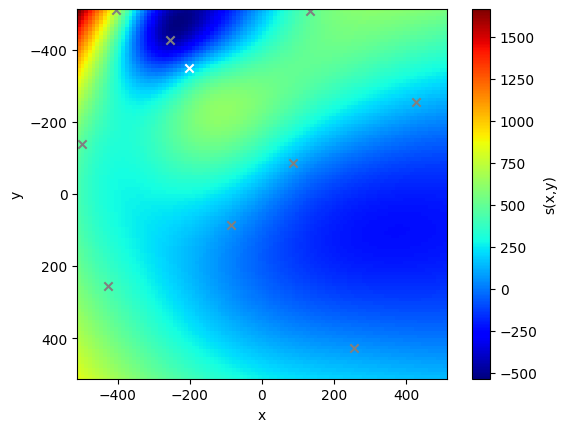

Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [159.7776503  203.22576621]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [ -94.21152196 -501.23172721]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-256.         -511.90192178]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-290.80666651 -416.92490953]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [  20.52515237 -344.6523165 ]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [ 193.16743603 -312.22683076]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-188.60739535 -448.65274194]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-249.44443075 -426.66666667]
Best value of  -449.3048641148615 

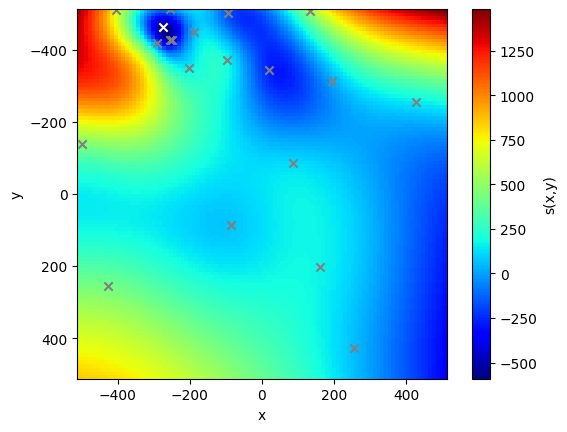

Best value of  -583.6308020250951  at  [-274.17606647 -462.93505777]
Last sample point at  [-265.89579429 -449.8226836 ]
Best value of  -612.9005260282383  at  [-274.17606647 -458.53000541]
Last sample point at  [-274.17606647 -458.53000541]
Best value of  -612.9005260282383  at  [-274.17606647 -458.53000541]
Last sample point at  [-391.08654553 -395.87114579]
Best value of  -612.9005260282383  at  [-274.17606647 -458.53000541]
Last sample point at  [-351.02850821 -458.53000541]
Best value of  -665.0239934545411  at  [-279.05396733 -454.26920788]
Last sample point at  [-279.05396733 -454.26920788]
Best value of  -683.4660281972225  at  [-283.06566504 -454.26920788]
Last sample point at  [-283.06566504 -454.26920788]
Best value of  -683.4660281972225  at  [-283.06566504 -454.26920788]
Last sample point at  [-283.06566504 -288.35627347]
Best value of  -683.4660281972225  at  [-283.06566504 -454.26920788]
Last sample point at  [-458.93467587 -411.81125554]
Best value of  -693.129935660418

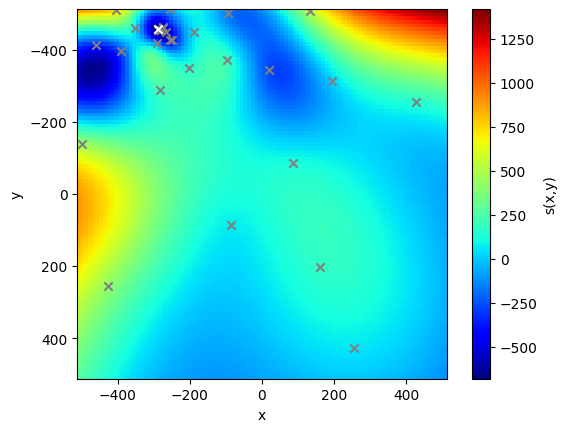

Best value of  -697.7028904065485  at  [-288.17847914 -456.83559265]
Last sample point at  [-330.69661236 -342.07449235]
Best value of  -697.7028904065485  at  [-288.17847914 -456.83559265]
Last sample point at  [-303.30503332 -511.60601414]
Best value of  -698.8226713753485  at  [-292.10095072 -456.83559265]
Last sample point at  [-292.10095072 -456.83559265]
Best value of  -699.4915477528475  at  [-290.02336192 -456.83559265]
Last sample point at  [-290.02336192 -456.83559265]
Best value of  -699.4915477528475  at  [-290.02336192 -456.83559265]
Last sample point at  [-502.40024088 -456.83559265]
Best value of  -699.4915477528475  at  [-290.02336192 -456.83559265]
Last sample point at  [-397.39197473 -348.5911487 ]
Best value of  -699.4915477528475  at  [-290.02336192 -456.83559265]
Last sample point at  [-290.02336192 -461.32488905]
Best value of  -701.3572029476386  at  [-290.02336192 -458.89488413]
Last sample point at  [-290.02336192 -458.89488413]
Best value of  -701.357202947638

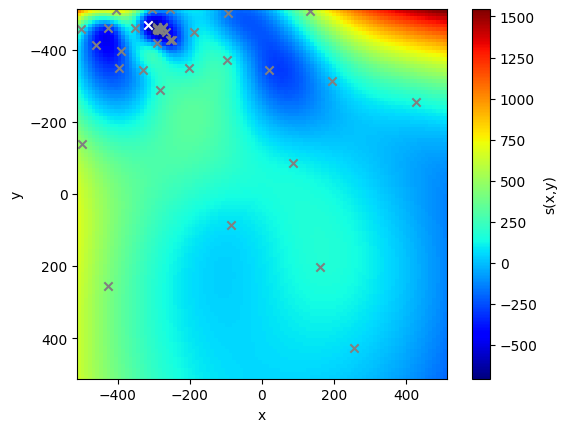

Best value of  -701.3572029476386  at  [-290.02336192 -458.89488413]
Last sample point at  [-301.70639205 -458.89488413]
Best value of  -702.9099255104129  at  [-292.13145267 -458.89488413]
Last sample point at  [-292.13145267 -458.89488413]
Best value of  -702.9099255104129  at  [-292.13145267 -458.89488413]
Last sample point at  [-232.32071176 -380.61063788]
Best value of  -702.9099255104129  at  [-292.13145267 -458.89488413]
Last sample point at  [-129.9945023  -458.89488413]
Best value of  -702.9099255104129  at  [-292.13145267 -458.89488413]
Last sample point at  [-296.74222326 -458.89488413]
Best value of  -703.7619334958438  at  [-292.13145267 -460.5752934 ]
Last sample point at  [-292.13145267 -460.5752934 ]
Best value of  -703.7619334958438  at  [-292.13145267 -460.5752934 ]
Last sample point at  [-349.95890537 -510.06159919]
Best value of  -703.7619334958438  at  [-292.13145267 -460.5752934 ]
Last sample point at  [-227.21319086 -472.00323556]
Best value of  -704.613008472107

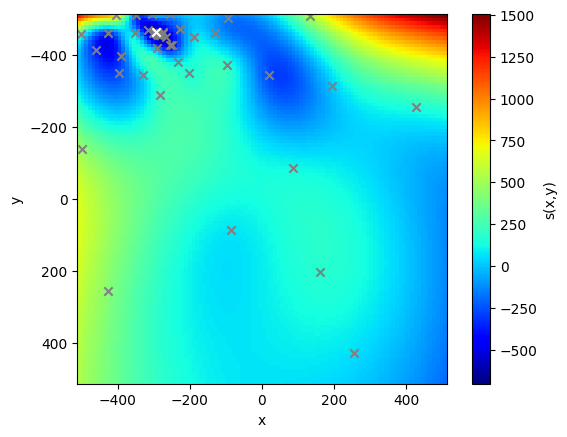

Best value of  -704.6409283597071  at  [-294.81949411 -461.48311514]
Last sample point at  [-294.81949411 -370.87999499]
Best value of  -704.6409283597071  at  [-294.81949411 -461.48311514]
Last sample point at  [-294.81949411 -487.45819941]
Best value of  -704.6409283597071  at  [-294.81949411 -461.48311514]
Last sample point at  [-293.30312284 -461.48311514]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-294.15135282 -461.48311514]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-315.10766915 -437.11788192]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-300.02334534 -474.99598496]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-294.15135282 -470.20078401]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-294.15135282 -462.28294983]
Best value of  -704.747858727337

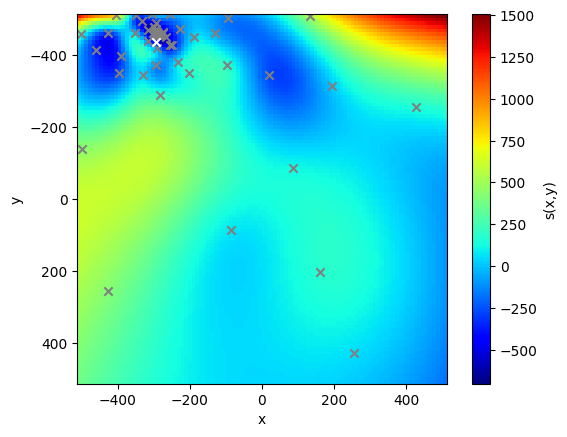

Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-296.59597461 -463.65052803]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-294.15135282 -460.40241319]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-332.56983132 -461.48311514]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-282.58877342 -461.48311514]
Best value of  -704.7478587273372  at  [-294.15135282 -461.48311514]
Last sample point at  [-294.15135282 -466.43634746]
Best value of  -704.7522701760804  at  [-294.15135282 -461.85318512]
Last sample point at  [-294.15135282 -461.85318512]
Best value of  -704.7522701760804  at  [-294.15135282 -461.85318512]
Last sample point at  [-294.15135282 -446.129674  ]
Best value of  -704.7522701760804  at  [-294.15135282 -461.85318512]
Last sample point at  [-302.51291903 -465.86554675]
Best value of  -704.752270176080

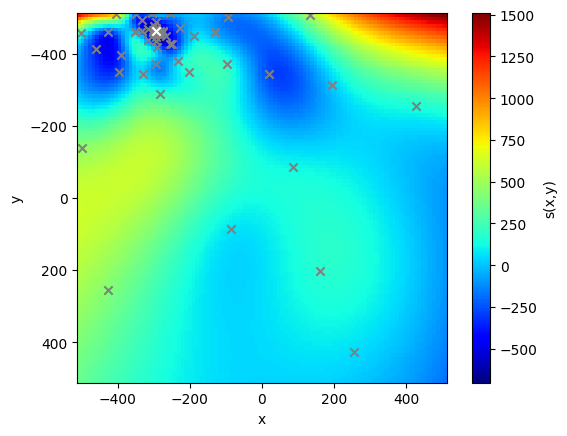

Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
Last sample point at  [-294.58904994 -452.55725963]
Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
Last sample point at  [-300.02124206 -461.85318512]
Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
Last sample point at  [-295.67174745 -461.85318512]
Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
Last sample point at  [-294.58904994 -462.28376756]
Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
Last sample point at  [nan nan]
Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
Last sample point at  [-511.99593603  511.99966826]
Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
Last sample point at  [ 512. -512.]
Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
Last sample point at  [512.         511.99999996]
Best value of  -704.8003100589178  at  [-294.58904994 -461.85318512]
L

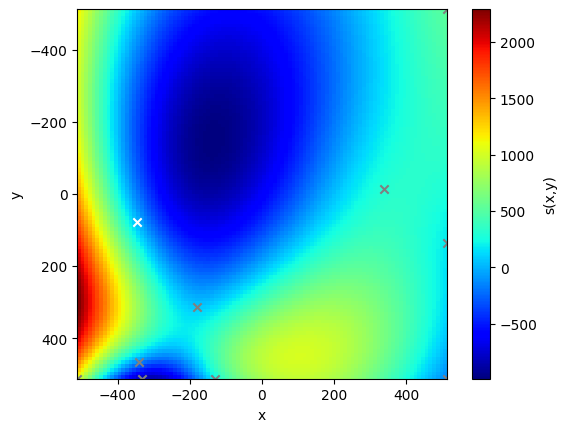

Best value of  -793.3361179707454  at  [-332.41185381  511.99999899]
Last sample point at  [511.99999997 -94.33404277]
Best value of  -793.3361179707454  at  [-332.41185381  511.99999899]
Last sample point at  [-512.          104.57059721]
Best value of  -793.3361179707454  at  [-332.41185381  511.99999899]
Last sample point at  [ 97.10477759 511.99890676]
Best value of  -793.3361179707454  at  [-332.41185381  511.99999899]
Last sample point at  [ 337.62860385 -512.        ]
Best value of  -793.3361179707454  at  [-332.41185381  511.99999899]
Last sample point at  [511.99999819 334.42963142]
Best value of  -793.3361179707454  at  [-332.41185381  511.99999899]
Last sample point at  [353.73701852 225.28565203]
Best value of  -850.8083219288092  at  [350.47439756 512.        ]
Last sample point at  [350.47439756 512.        ]
Best value of  -850.8083219288092  at  [350.47439756 512.        ]
Last sample point at  [-130.90201245 -120.13440936]
Best value of  -850.8083219288092  at  [350.47

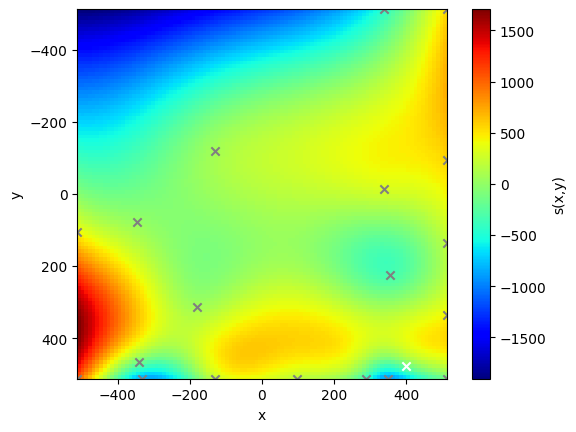

Best value of  -850.8083219288092  at  [350.47439756 512.        ]
Last sample point at  [ 30.80655298 315.07481721]
Best value of  -850.8083219288092  at  [350.47439756 512.        ]
Last sample point at  [ 511.99999999 -362.74435904]
Best value of  -850.8083219288092  at  [350.47439756 512.        ]
Last sample point at  [-289.13726904  511.99999979]
Best value of  -858.4075843964931  at  [357.25006275 512.        ]
Last sample point at  [357.25006275 512.        ]
Best value of  -858.4075843964931  at  [357.25006275 512.        ]
Last sample point at  [-327.47883771  -96.19122477]
Best value of  -858.4075843964931  at  [357.25006275 512.        ]
Last sample point at  [ 255.43160924 -154.51550698]


OptimizeResult(x=array([357.25006275, 512.        ]), fx=-858.4075843964931, nit=2, nfev=100, sample=array([[-426.66666667,  256.        ],
       [-256.        , -426.66666667],
       [ -85.33333333,   85.33333333],
       [  85.33333333,  -85.33333333],
       [ 256.        ,  426.66666667],
       [ 426.66666667, -256.        ],
       [-499.37256386, -138.16103101],
       [ 132.18897963, -506.29499397],
       [-403.38662062, -510.27133325],
       [-201.22857228, -349.82773298],
       [ 159.7776503 ,  203.22576621],
       [ -94.21152196, -501.23172721],
       [-256.        , -511.90192178],
       [-290.80666651, -416.92490953],
       [  20.52515237, -344.6523165 ],
       [ 193.16743603, -312.22683076],
       [-188.60739535, -448.65274194],
       [-249.44443075, -426.66666667],
       [ -95.85661081, -369.70616447],
       [-274.17606647, -462.93505777],
       [-265.89579429, -449.8226836 ],
       [-274.17606647, -458.53000541],
       [-391.08654553, -395.87114579],
  

In [7]:
np.random.seed(3)

callback = {
    "bayesian_optimization":callback_gp,
    "cptv":callback_rbf,
    "cptvl":callback_rbf,
    "surrogate_optimization":callback_rbf_tv,
    "multistart_msrs":callback_rbf,
    "dycors":callback_rbf
}
methodstr = "cptv"

getattr(bbopt, methodstr)(lambda x: [objf[funcstr](xi) for xi in x], bounds=bounds, maxeval=100, callback=callback[methodstr])